# Problem
1. 100 points

Create a VQE classifier with Qiskit to perform a binary classification on the following synthetic dataset.

A) Experiment with different ways to preprocess your data.

B) Define a feature map (parameterized QC) that produces a satisfying accuracy in training and test.
You can design your own, or experiment with the prebuilt set of circuits from the [Qiskit Circuit Library](https://docs.quantum.ibm.com/api/qiskit/circuit_library).

Note: 

In this p-set multiple approaches will be valid and lead to good results. Let's share our findings.
You can volunteer to present your apporach in the next lecture.



# Solution

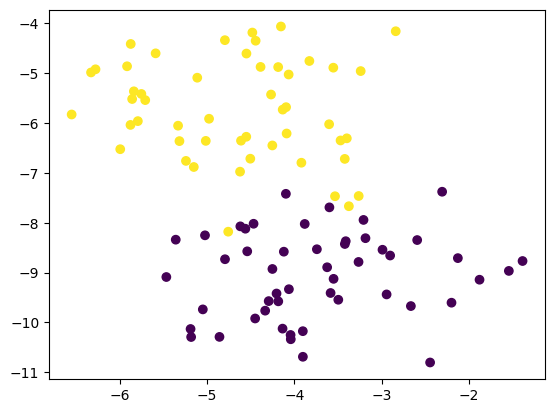

In [18]:
'''Creating a fake data-set'''
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

feature_dim = 2
X,y = make_blobs(n_samples=100, n_features=feature_dim, centers=2)
plt.scatter(X[:,0],X[:,1],c=y)

Normally in machine learning, it is useful to plot the data in a pairplot to visualize the correlations between the features which gives us an idea of the separability of the data.

In [94]:
'''Defining a function to help with creating the pair plots'''
import pandas as pd
import seaborn as sns

def make_plot(df: pd.DataFrame, title: str = None):
    '''Function for creating the pairplots'''
    # The color palette is selected to match the scatter plot
    plot = sns.pairplot(df, hue = "class", palette={0: '#440154', 1: '#fde724'})
    if title:
        plot.figure.subplots_adjust(top=0.9)
        plot.figure.suptitle(title)
    return plot

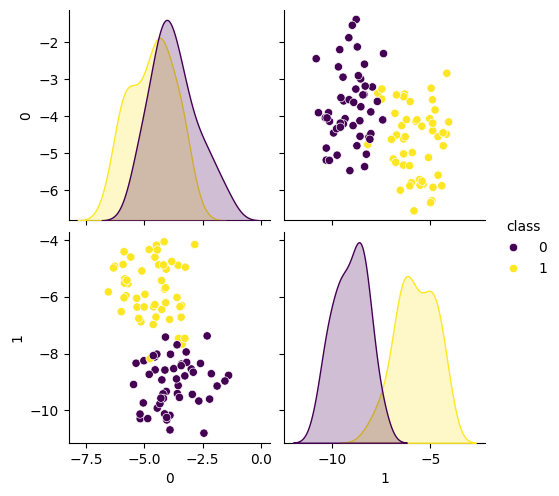

In [95]:
'''Plotting the data in a pairplot'''
df = pd.DataFrame(X)
df["class"] = pd.Series(y)

data = make_plot(df)

As can be seen, this data set has some overlap which cannot be reconciled in 2 dimensions.

Before we go on to use machine learning for this problem, we need test and training data sets. Since we don't have more data, we are just going to split the data we already have into a training set and a testing set.

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

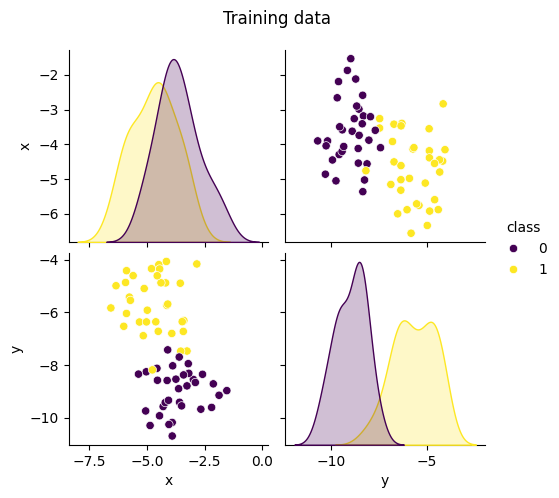

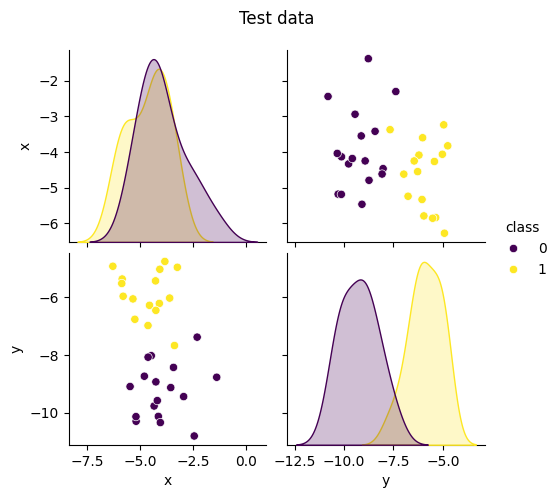

In [98]:
'''Plotting the split data sets'''
df_train = pd.DataFrame(X_train,columns=['x','y'])
df_train["class"] = pd.Series(y_train)

df_test = pd.DataFrame(X_test,columns=['x','y'])
df_test["class"] = pd.Series(y_test)

train_data = make_plot(df_train, title="Training data")
test_data = make_plot(df_test, title="Test data")

## Training a classical model on the data

As a baseline, it would be useful to see the ideal performance of a Support Vector Classifier model.

In [156]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, y_train)  # suppress printing the return value

train_score_c4 = svc.score(X_train, y_train)
test_score_c4 = svc.score(X_test, y_test)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.96
Classical SVC on the test dataset:     0.97


# Training a quantum model on the data

In [152]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit import QuantumCircuit

# This is here because the method we are using is depracated already
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
def qsvc_model(ansatz: QuantumCircuit):
    '''Function for testing the feature map (ansatz)'''
    sampler = AerSampler()
    fidelity = ComputeUncompute(sampler=sampler)
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=ansatz)
    qsvc = QSVC(quantum_kernel=kernel)
    qsvc.fit(X_train,y_train)

    score_train = qsvc.score(X_train, y_train)
    print(f"Test score: {score_train}")

    score_test = qsvc.score(X_test, y_test)
    print(f"Test score: {score_test}")

Starting with the feature map from the lecture

In [115]:
ansatz_zz = ZZFeatureMap(feature_dimension=feature_dim,reps=1)
qsvc_model(ansatz_zz)

Test score: 0.6865671641791045
Test score: 0.3939393939393939


Slightly altering the circuit barely produces any noticable difference.

In [140]:
ansatz = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
qsvc_model(ansatz)

Test score: 0.6567164179104478
Test score: 0.42424242424242425


Another feature map I found was the PauliFeatureMap 

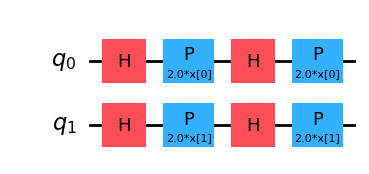

In [142]:
from qiskit.circuit.library import PauliFeatureMap

ansatz = PauliFeatureMap(feature_dimension=feature_dim,reps=2,entanglement='full',paulis="Z")
ansatz.decompose().draw("mpl")

This provides a slight improvement for the test_data, but this is still unacceptable accuracy.

In [143]:
qsvc_model(ansatz)

Test score: 0.6417910447761194
Test score: 0.45454545454545453


# Preprocessing
The single most important pre-processing step is to normalize your data.

In [147]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)

Recreating the train-test split

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [149]:
ansatz_zz = ZZFeatureMap(feature_dimension=feature_dim,reps=1)
qsvc_model(ansatz_zz)

Test score: 0.9701492537313433
Test score: 0.9696969696969697


In [161]:
ansatz = PauliFeatureMap(feature_dimension=feature_dim,reps=2,entanglement='full',paulis="Z")
qsvc_model(ansatz)

Test score: 0.9402985074626866
Test score: 1.0


As you can see, just normalizing our data is enough to create a much better model which even performs better than the classical model on the unnormalized data! In fact, the quantum model seems to perform slightly better in some cases (specifically on the test data set)!

In [177]:
svc = SVC()
_ = svc.fit(X_train, y_train)  # suppress printing the return value

train_score_c4 = svc.score(X_train, y_train)
test_score_c4 = svc.score(X_test, y_test)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.96
Classical SVC on the test dataset:     0.97


One thing to note is that the data set that I chose isn't entirely separable, which is why it is a bit difficult to get 100%. This mimicks real life data where you will almost never get a full 100% accuracy with a model. However, if I had chosen an easy dataset (of which there are plenty with this randomized generation of data), then all the scores after normalization would be 100%.

## Example on easy data

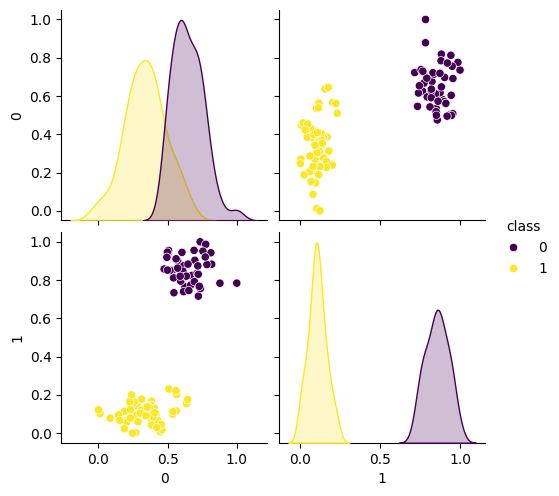

In [184]:
feature_dim = 2
X,y = make_blobs(n_samples=100, n_features=feature_dim, centers=2)
X = MinMaxScaler().fit_transform(X) # Normalization
df = pd.DataFrame(X)
df["class"] = pd.Series(y)

data = make_plot(df)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

In [186]:
'''Classical model'''

svc = SVC()
_ = svc.fit(X_train, y_train)  # suppress printing the return value

train_score_c4 = svc.score(X_train, y_train)
test_score_c4 = svc.score(X_test, y_test)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 1.00
Classical SVC on the test dataset:     1.00


In [187]:
'''Quantum model with ZZFeatureMap'''
qsvc_model(ansatz_zz)

Test score: 1.0
Test score: 1.0


And as you can see, even the "bad" featuremap from the lecture performs fantastically with this data set.